In [1]:
# RNN and FFNN for Toy data
# Segessenmann J. 2020

import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import torch.nn as nn

## Generate Data
Three sinus waves are generated with variation in their phase. The model predicts one wave from the other two.
The train Data X_train is a list with each entry of shape (window_size=50, channels=2) and Y_train a list with each entry of shape (window_size=50, channels=1). The window is iterating trough the samples of length N_samples=1000.

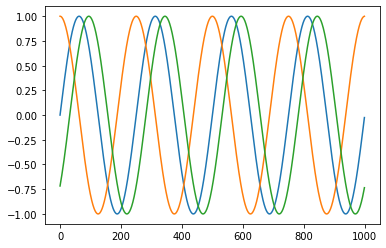

In [2]:
N_samples = 1000
N_turns = 4
x0 = np.sin(np.arange(0, N_turns*2*np.pi, N_turns*2*np.pi/N_samples))
x1 = np.cos(np.arange(0, N_turns*2*np.pi, N_turns*2*np.pi/N_samples))
x2 = np.sin(np.arange(-0.8, N_turns*2*np.pi-0.8, N_turns*2*np.pi/N_samples))
data = np.array([x0, x1, x2]).transpose()
plt.figure()
plt.plot(data)

# to tensor
data = torch.FloatTensor(data)

# split data
train_portion = 0.8
train_set = data[:int(train_portion * N_samples), :]
test_set = data[int(train_portion * N_samples):, :]

# prepare data for learning
window_size = 50
ch_in = [0, 1]
ch_out = [2]
X_train, Y_train, X_test, Y_test = [], [], [], []
for i in range(train_set.shape[0] - window_size):
    X_train.append(train_set[i:i+window_size, ch_in])
    Y_train.append(train_set[i+window_size-1, ch_out])
for i in range(test_set.shape[0] - window_size):
    X_test.append(test_set[i:i+window_size, ch_in])
    Y_test.append(test_set[i+window_size-1, ch_out])

## RNN
Vanilla RNN with two input nodes and one hidden layer node. The hidden layer node is the output as well.

In [3]:
class RNN(nn.Module):
    def __init__(self, input_size=len(ch_in), hidden_size=1):
        super().__init__()
        # Variables
        self.hidden_size = hidden_size
        # Layers
        self.rnn = nn.RNN(input_size, hidden_size)      

    def forward(self, X):
        # Inizialize hidden node
        self.hidden = torch.zeros(1, 1, self.hidden_size)
        # Forward path
        _, self.hidden = self.rnn(X.view(X.shape[0], 1, X.shape[1]), self.hidden)
        return self.hidden.view(-1)  # last value of each output channel

Epoch: 0 Loss: 0.6745216957202923
Epoch: 1 Loss: 0.4109705640420253
Epoch: 2 Loss: 0.2798942474956394
Epoch: 3 Loss: 0.2133077330526741
Epoch: 4 Loss: 0.1733236586564156
Epoch: 5 Loss: 0.14661360892089706
Epoch: 6 Loss: 0.12746682554142083
Epoch: 7 Loss: 0.11303526350688883
Epoch: 8 Loss: 0.101743733072634
Epoch: 9 Loss: 0.09265158707560348
Time used [s]: 29.756941318511963


(Text(0.5, 0, 'epoch'), Text(0, 0.5, 'loss'))

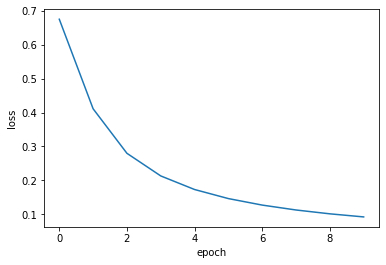

In [9]:
model = RNN()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 10

temp_loss = []
epoch_loss = []

start_time = time.time()

for epoch in range(epochs):
    for idx, X in enumerate(X_train):
        optimizer.zero_grad()
        Y_pred = model(X)
        loss = criterion(Y_pred, Y_train[idx])
        loss.backward()
        optimizer.step()
        temp_loss.append(loss.item())

    epoch_loss.append(np.mean(np.asarray(temp_loss)))
    print(f'Epoch: {epoch} Loss: {epoch_loss[epoch]}')

total_time = time.time() - start_time
print('Time used [s]: ' + str(total_time))

plt.figure()
plt.plot(np.asarray(epoch_loss))
plt.xlabel('epoch'), plt.ylabel('loss')

[('weight_ih_l0',
  Parameter containing:
  tensor([[ 0.6527, -0.6622]], requires_grad=True)),
 ('weight_hh_l0',
  Parameter containing:
  tensor([[0.3393]], requires_grad=True)),
 ('bias_ih_l0',
  Parameter containing:
  tensor([-0.0049], requires_grad=True)),
 ('bias_hh_l0',
  Parameter containing:
  tensor([0.0087], requires_grad=True))]

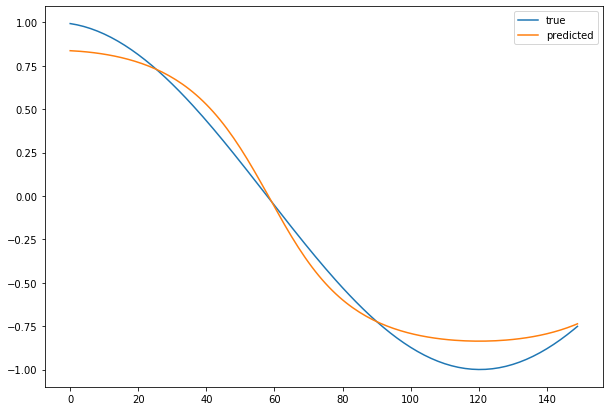

In [10]:
model.eval()

Y_preds = []
for idx, X in enumerate(X_test):
    with torch.no_grad():
        model.hidden = torch.zeros(1, 1, model.hidden_size)
        Y_preds.append(model(X).numpy())

preds = np.asarray(Y_preds)
Y_test_np = np.asarray([idx.numpy() for idx in Y_test])

fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(Y_test_np[:,0], label='true')
ax.plot(preds[:,0], label='predicted')
ax.legend()

[(para[0],para[1]) for para in list(model.rnn.named_parameters())]

## FFNN
Same architecture as RNN. The number of fully connected layers is window_size=50, so its a 50-layer FFNN with shared parameters (the same layer is used 50 times). Input nodes and hidden nodes are concatenated.

In [6]:
class FFNN(nn.Module):
    def __init__(self, window_size=window_size, input_channel_size=len(ch_in), hidden_size=1):
        super().__init__()
        # Variables
        self.hidden_size = hidden_size
        self.input_channel_size = input_channel_size
        # Create FC Layer
        self.fc = nn.Linear(self.input_channel_size + self.hidden_size, self.hidden_size)
        
    def forward(self, X):
        # Initialize hidden node
        h = torch.zeros(self.hidden_size, dtype=torch.float32)
        # Forward path
        for i in range(X.shape[0]):
            fc_in = torch.cat((X[i,:], h), 0)
            h = torch.tanh(self.fc(fc_in))
        return h

Epoch: 0 Loss: 0.9031297826313627
Epoch: 1 Loss: 0.5342501800954551
Epoch: 2 Loss: 0.36275256410307954
Epoch: 3 Loss: 0.27489816942828316
Epoch: 4 Loss: 0.22213908389197082
Epoch: 5 Loss: 0.1869438725322735
Epoch: 6 Loss: 0.16176836500719458
Epoch: 7 Loss: 0.14284194815472878
Epoch: 8 Loss: 0.12807464105380373
Epoch: 9 Loss: 0.11621692360404465
Time used [s]: 39.370502948760986


(Text(0.5, 0, 'epoch'), Text(0, 0.5, 'loss'))

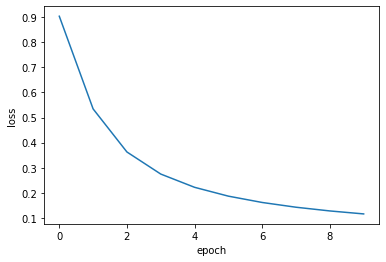

In [7]:
model = FFNN()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 10

temp_loss = []
epoch_loss = []

start_time = time.time()

for epoch in range(epochs):
    for idx, X in enumerate(X_train):
        optimizer.zero_grad()
        Y_pred = model(X)
        loss = criterion(Y_pred, Y_train[idx])
        loss.backward()
        optimizer.step()
        temp_loss.append(loss.item())

    epoch_loss.append(np.mean(np.asarray(temp_loss)))
    print(f'Epoch: {epoch} Loss: {epoch_loss[epoch]}')
    
total_time = time.time() - start_time
print('Time used [s]: ' + str(total_time))

plt.figure()
plt.plot(np.asarray(epoch_loss))
plt.xlabel('epoch'), plt.ylabel('loss')

Weights: tensor([[ 0.7097, -0.7158,  0.2695]])
Bias: tensor([0.0032])


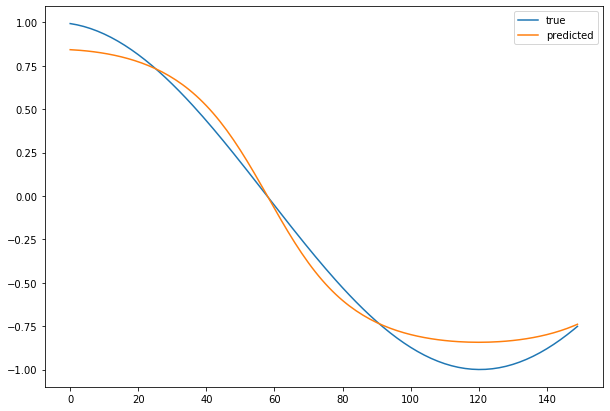

In [8]:
model.eval()

Y_preds = []
for idx, X in enumerate(X_test):
    with torch.no_grad():
        Y_preds.append(model(X).numpy())

preds = np.asarray(Y_preds)
Y_test_np = np.asarray([idx.numpy() for idx in Y_test])

fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(Y_test_np[:,0], label='true')
ax.plot(preds[:,0], label='predicted')
ax.legend()

print('Weights: ' + str(model.fc.weight.data))
print('Bias: ' + str(model.fc.bias.data))